In [1]:
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, cv2, random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

np.random.seed(128)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
TEST_SIZE = 0.3
RANDOM_STATE = 42
SAMPLE_SIZE =2000
IMG_SIZE = 256
RESNET_WEIGHTS_PATH = '/content/drive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

In [4]:
df = pd.read_excel ('/content/drive/My Drive/INFO_subjects_out.xlsx',index=None)
df.set_index(['ID_P','ID_Cy'],inplace=True)
df1=df.loc[df.state==1]
df1['class'] = 0 # For healthy
df1.loc[df1.diagnosis=='functional dysphonia','class']=1
df1.loc[df1.diagnosis=='paresis','class']=2 # For paresis disease
df1.loc[df1.diagnosis=='polyp','class']=3 # For polyp disease
df1.loc[df1.diagnosis=='carcinoma','class']=4 # For carcinoma disease

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
#ch1 = ['/content/drive/My Drive/data_image/C_'+str(i)+'/' for i in range(1,729)]
ch1 = ['/content/drive/My Drive/data_image/' + i + '/' for i in os.listdir('/content/drive/My Drive/data_image/')]
k=-1
data0=[]
data1=[]
data2=[]
data3=[]
data4=[]
for x in ch1:

  l = os.listdir(x)
  k+=1
  for j in range(len(l)):
    img_p = x + l[j]
    img = cv2.imread(img_p)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    val = df1.iloc[k]['class']
    label=np.zeros(5)
    label[val]=1
    if val == 0 :
      data0.append([np.array(img) , label])
    if val == 1 :
      data1.append([np.array(img) , label])
    if val == 2 :
      data2.append([np.array(img) , label])
    if val == 3 :
      data3.append([np.array(img) , label])
    if val == 4 :
      data4.append([np.array(img) , label])
  
data = data0[0:1241] + data1[0:1241] +data2[0:1241] +data3[0:1241] +data4[0:1241] 
np.random.shuffle(data)
print(len(data))

6205


In [6]:
  X, Y = [], []
for x in data:
    X.append(x[0])
    Y.append(x[1])
X = np.array(X).reshape(-1,256,256,3)
Y = np.array(Y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [9]:
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

[866. 861. 889. 869. 858.]
[375. 380. 352. 372. 383.]


In [10]:
#Instantiating ResNet50
base_model_resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3),classes=5)
base_model_resnet.trainable = True
#Defining and Adding layers
model_resnet=Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(1024,activation=('relu'),input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(0.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(0.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(5,activation=('softmax'))) #This is the classification layer

In [11]:
batch_size= 100
epochs=20
learn_rate=0.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
#Compile
model_resnet.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [12]:
train_model = model_resnet.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs, 
                  verbose=1)

Epoch 1/20
44/44 [==============================] - 27s 620ms/step - loss: 1.6331 - accuracy: 0.3590
Epoch 2/20
44/44 [==============================] - 27s 609ms/step - loss: 1.2726 - accuracy: 0.4957
Epoch 3/20
44/44 [==============================] - 27s 610ms/step - loss: 1.1374 - accuracy: 0.5337
Epoch 4/20
44/44 [==============================] - 27s 609ms/step - loss: 1.0603 - accuracy: 0.5609
Epoch 5/20
44/44 [==============================] - 27s 610ms/step - loss: 0.9921 - accuracy: 0.5805
Epoch 6/20
44/44 [==============================] - 27s 610ms/step - loss: 0.9653 - accuracy: 0.5901
Epoch 7/20
44/44 [==============================] - 27s 609ms/step - loss: 0.8807 - accuracy: 0.6129
Epoch 8/20
44/44 [==============================] - 27s 609ms/step - loss: 0.8369 - accuracy: 0.6417
Epoch 9/20
44/44 [==============================] - 27s 610ms/step - loss: 0.7653 - accuracy: 0.6597
Epoch 10/20
44/44 [==============================] - 27s 610ms/step - loss: 0.6840 - accura

In [13]:
pred = model_resnet.predict (X_test)
score= sum (np.argmax(pred,axis=1) == np.argmax(y_test,axis=1))
score = score/len(y_test) 
print(round(score,3))

0.718


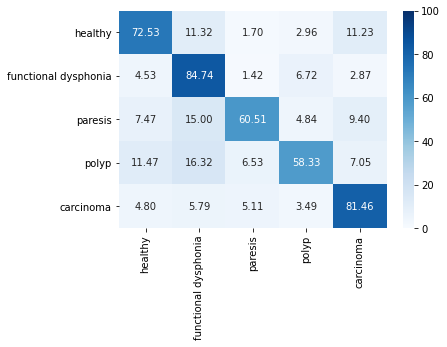

In [14]:
y1 = np.argmax(pred,axis=1)
y2 = np.argmax(y_test,axis=1)
cm = confusion_matrix(y2, y1)
cm = cm.astype('float') / cm.sum(axis=1) 
sns.heatmap(pd.DataFrame(cm*100,columns=['healthy','functional dysphonia','paresis','polyp','carcinoma'],index=['healthy','functional dysphonia','paresis','polyp','carcinoma']),
            annot=True, vmin=0.0, vmax=100.0, fmt='.2f',cmap='Blues');